# Quantstar - Revolutionizing Satellite Operations

## Imports

In [1]:
from mqt import ddsim
import numpy as np

from mqt.problemsolver import utils
from mqt.problemsolver.utils import  QAOA, W_QAOA

from qiskit import Aer, execute
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters.quadratic_program_to_qubo import (
    QuadraticProgramToQubo,
)
from qiskit.algorithms.optimizers import L_BFGS_B, ADAM, SPSA

import matplotlib.pyplot as plt

import warnings
import time

## Create arbitrary Satellite Problem Instance

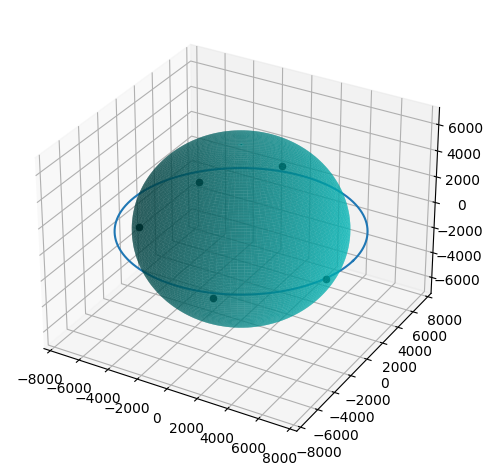

In [2]:
num_requests = 5
ac_reqs = utils.init_random_acquisition_requests(num_requests)
utils.plot_acqisition_requests(ac_reqs)

## Create Docplex Model and Convert it to QUBO Formulation

In [3]:
penalty = None
mdl = utils.create_satellite_doxplex(ac_reqs)
converter, qubo = utils.convert_docplex_to_qubo(mdl, penalty=penalty)
print(qubo.prettyprint())
print(qubo.to_ising())
converter, qubo = utils.convert_docplex_to_qubo(mdl)
print(qubo.to_ising())
for elem in qubo.to_ising():
    print(elem, type(elem))

Problem name: satellite model

Minimize
  6*requests_0*requests_3 - requests_0 - requests_1 - requests_2 - requests_3
  - requests_4

Subject to
  No constraints

  Binary variables (5)
    requests_0 requests_1 requests_2 requests_3 requests_4

(PauliSumOp(SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IZIIZ'],
              coeffs=[-1. +0.j,  0.5+0.j,  0.5+0.j, -1. +0.j,  0.5+0.j,  1.5+0.j]), coeff=1.0), -1.0)
(PauliSumOp(SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IZIIZ'],
              coeffs=[-1. +0.j,  0.5+0.j,  0.5+0.j, -1. +0.j,  0.5+0.j,  1.5+0.j]), coeff=1.0), -1.0)
-1.0 * IIIIZ
+ 0.5 * IIIZI
+ 0.5 * IIZII
- 1.0 * IZIII
+ 0.5 * ZIIII
+ 1.5 * IZIIZ <class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'>
-1.0 <class 'numpy.float64'>


## QAOA Solution Implementation

In [4]:
def solve_using_qaoa(qubo) -> bool:
    qaoa = QAOA(QAOA_params={"reps":3, "optimizer": SPSA(maxiter=100)})
    qc_qaoa, res_qaoa = qaoa.get_solution(qubo)

    num_shots = 10000
    backend = ddsim.DDSIMProvider().get_backend("qasm_simulator")
    job = execute(qc_qaoa, backend, shots=num_shots)
    qaoa_counts = job.result().get_counts(qc_qaoa)

    probs={}
    for key in qaoa_counts:
        bin_val = bin(int(key, 2))[2:].zfill(len(qubo.variables))
        state = converter.interpret(np.array(list(bin_val), dtype=int))
        probs[bin_val] = qaoa_counts[key]/num_shots

    most_likely_eigenstate_qaoa = utils.sample_most_likely(probs)
    most_likely_eigenstate_qaoa = np.array([int(s) for s in most_likely_eigenstate_qaoa], dtype=float)
    if utils.check_solution(ac_reqs, most_likely_eigenstate_qaoa):
        solution = most_likely_eigenstate_qaoa
        value = utils.calc_sol_value(ac_reqs, most_likely_eigenstate_qaoa)
        return solution, value
    else:
        return False

In [5]:
ac_reqs = utils.init_random_acquisition_requests(5)
mdl = utils.create_satellite_doxplex(ac_reqs)
converter, qubo = utils.convert_docplex_to_qubo(mdl)
qaoa = QAOA(QAOA_params={"reps":1, "optimizer": SPSA(maxiter=1)})
qc_qaoa, res_qaoa = qaoa.get_solution(qubo)
print(qubo.to_ising())
print(qubo)
print(np.array(qubo.to_ising()[0].primitive.coeffs, dtype=float))
print(qubo.to_ising()[1])
print(qaoa.ansatz.decompose(reps=2))

(PauliSumOp(SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IIZZI', 'IZIIZ', 'IZIZI', 'ZIIIZ'],
              coeffs=[-2.5+0.j, -2.5+0.j, -1. +0.j, -2.5+0.j, -1. +0.j,  1.5+0.j,  1.5+0.j,
  1.5+0.j,  1.5+0.j]), coeff=1.0), 3.5)
minimize 6*requests_0*requests_3 + 6*requests_0*requests_4 + 6*requests_1*requests_2 + 6*requests_1*requests_3 - requests_0 - requests_1 - requests_2 - requests_3 - requests_4 (5 variables, 0 constraints, 'satellite model')
[-2.5 -2.5 -1.  -2.5 -1.   1.5  1.5  1.5  1.5]
3.5
     ┌─────────────┐┌───────────────┐                              »
q_0: ┤ U3(π/2,0,π) ├┤ Rz(-5.0*γ[0]) ├────────────────■─────────────»
     ├─────────────┤├───────────────┤                │             »
q_1: ┤ U3(π/2,0,π) ├┤ Rz(-5.0*γ[0]) ├─■──────────────┼─────────────»
     ├─────────────┤├───────────────┤ │ZZ(3.0*γ[0])  │             »
q_2: ┤ U3(π/2,0,π) ├┤ Rz(-2.0*γ[0]) ├─■──────────────┼─────────────»
     ├─────────────┤├───────────────┤                │ZZ(3.0*γ[0]) »
q

/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_16060/207505577.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  print(np.array(qubo.to_ising()[0].primitive.coeffs, dtype=float))


### Execution

In [6]:
num_runs = 5
max_problem_size_qaoa = 10
res_all_qaoa_times = []
res_all_qaoa = []
for i in range (2, max_problem_size_qaoa):
    ac_reqs = utils.init_random_acquisition_requests(i)
    mdl = utils.create_satellite_doxplex(ac_reqs)
    converter, qubo = utils.convert_docplex_to_qubo(mdl)
    print(i)
    res_tmp = []
    res_tmp_time = []
    success = 0
    for j in range(num_runs):
        start_time = time.time()
        if solve_using_qaoa(qubo):
            success += 1
        res_tmp_time.append(time.time()-start_time)
    res_all_qaoa.append(success/num_runs)
    res_all_qaoa_times.append(sum(res_tmp_time)/num_runs)

2
3
4
5
6
7
8
9


## W-QAOA Solution

In [7]:
def solve_using_w_qaoa(qubo) -> bool:
    wqaoa = W_QAOA()
    qc_wqaoa, res_wqaoa = wqaoa.get_solution(qubo)
    return res_wqaoa

### Execution

In [8]:
num_runs = 5
max_problem_size_wqaoa = 10
res_all_wqaoa_times = []
res_all_wqaoa = []
for i in range (2, max_problem_size_wqaoa):
    print(i)
    ac_reqs = utils.init_random_acquisition_requests(i)
    mdl = utils.create_satellite_doxplex(ac_reqs)
    converter, qubo = utils.convert_docplex_to_qubo(mdl)
    res_tmp = []
    res_tmp_time = []
    success = 0
    for j in range(num_runs):
        start_time = time.time()
        res_w_qaoa = solve_using_w_qaoa(qubo)
        if res_w_qaoa.status.value==0:
            success += 1
        res_tmp_time.append(time.time()-start_time)
    res_all_wqaoa.append(success/num_runs)
    res_all_wqaoa_times.append(sum(res_tmp_time)/num_runs)

2
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
3
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
4
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
5
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
6
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimizer not specified, using L-BFGS-B.
Optimi

## Generate Plots

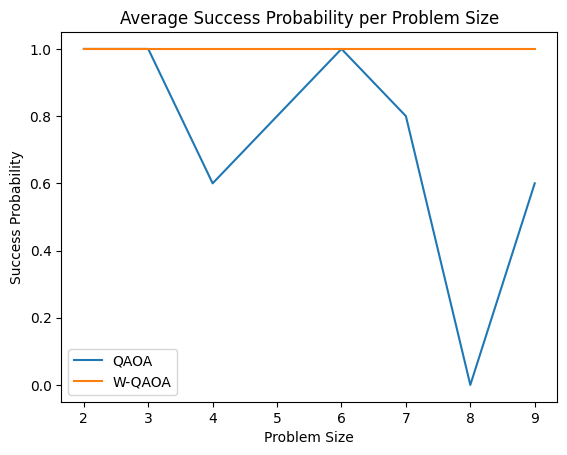

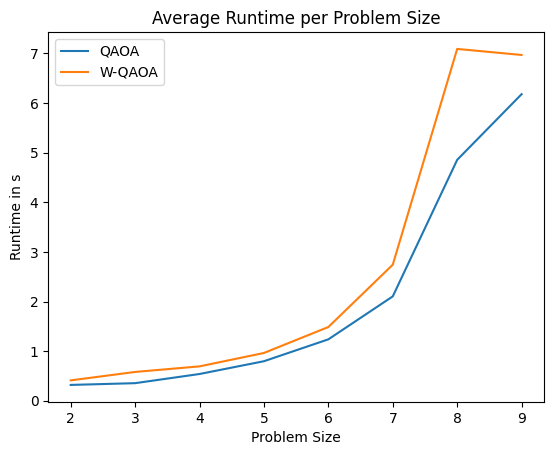

In [9]:
plt.plot(range(2, max_problem_size_qaoa), res_all_qaoa, label="QAOA")
plt.plot(range(2, max_problem_size_wqaoa), res_all_wqaoa, label="W-QAOA")
plt.title("Average Success Probability per Problem Size")
plt.xlabel("Problem Size")
plt.ylabel("Success Probability")
plt.legend()
plt.show()

plt.plot(range(2, max_problem_size_qaoa), res_all_qaoa_times, label="QAOA")
plt.plot(range(2, max_problem_size_wqaoa), res_all_wqaoa_times, label="W-QAOA")
plt.title("Average Runtime per Problem Size")
plt.xlabel("Problem Size")
plt.ylabel("Runtime in s")
plt.legend()
plt.show()